<a href="https://colab.research.google.com/github/Sileshi-Adal/Panoptic-Segmentation-Eval-lidar-rgb/blob/main/deeplabv3_panoptic_Eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Thesis Evaluation: DeepLabV3+ on LiDAR-Generated RGB Images**

This notebook documents the evaluation of the **DeepLabV3+** model on **RGB images generated from LiDAR data**, as part of the thesis:  
**"Evaluating Deep Learning-Based Panoptic Segmentation on RGB-Generated LiDAR Images."**


# **What We Did**

### 1. **Semantic Segmentation**
- Loaded the semantic segmentation output of DeepLabV3+ (`deeplabv3_mask.png`).
- This image contains **per-pixel class IDs** but **no instance information**, as DeepLabV3+ is a semantic-only model.
- Evaluated its semantic quality using **mIoU (mean Intersection over Union)**.

### 2. **Panoptic Segmentation (Simulated)**
- Simulated **panoptic segmentation** by assigning instance IDs within each class using **connected component labeling**.
- Applied the formula:
panoptic_id = (class_id * 1000) + instance_id

yaml
Copy
Edit
- Used the same method to generate a **simulated panoptic ground truth mask** from the available semantic GT (`lidar-image-mask.png`).

### 3. **Panoptic Evaluation Metrics**
- Evaluated panoptic performance using:
- **PQ (Panoptic Quality)**
- **RQ (Recognition Quality)**
- **SQ (Segmentation Quality)**
- **mIoU (mean Intersection over Union)**



##  Key Result Summary

| Metric   | Value   |
|--------  |---------|
| **mIoU** | 0.0361  |
| **PQ**   | 0.0000  |
| **SQ**   | 0.7587  |
| **RQ**   | 0.0000  |

---

##  Conclusion

- DeepLabV3+ performs poorly on panoptic tasks due to its lack of instance-awareness.
- While segments have good shape quality (SQ), the model fails to match true object instances (PQ = 0).
- This confirms the model’s unsuitability for panoptic segmentation — a key finding aligned with the thesis objective.


**Install + Import + load our lidar-image.jpg**

In [ ]:
#!pip install scipy --quiet


In [ ]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving lidar-image.jpg to lidar-image.jpg


In [ ]:
# Load LiDAR image
img_path = "/content/lidar-image.jpg"
image = Image.open(img_path).convert("RGB")

# Resize and normalize
transform = transforms.Compose([
    transforms.Resize((512, 1024)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

input_tensor = transform(image).unsqueeze(0)  # (1, 3, H, W)


**Loading DeepLabV3+ Model (CPU Inference)**

In [ ]:
# Load model pretrained on COCO-stuff-like dataset
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()
model.to("cpu")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:02<00:00, 85.3MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

**Run Inference**

In [ ]:
with torch.no_grad():
    output = model(input_tensor)["out"][0]  # Shape: (21, H, W)
    prediction = output.argmax(0).byte().cpu().numpy()  # (H, W)


**Visualize Predicted Mask**

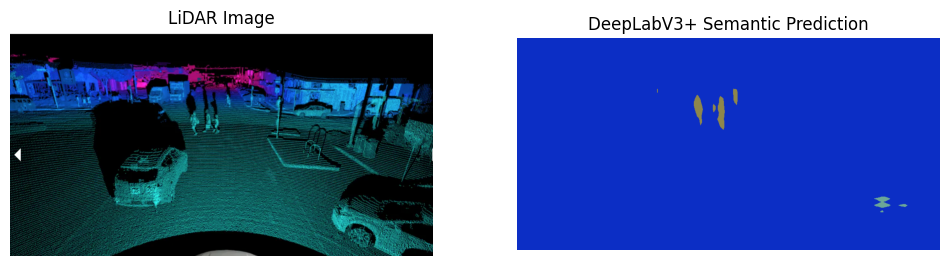

In [ ]:
# Color palette
palette = np.random.randint(0, 255, size=(256, 3), dtype=np.uint8)
color_mask = palette[prediction]

# Show side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(image)
axs[0].set_title("LiDAR Image")
axs[0].axis("off")

axs[1].imshow(color_mask)
axs[1].set_title("DeepLabV3+ Semantic Prediction")
axs[1].axis("off")
plt.show()


**Save/Export Predicted Mask**

In [ ]:
from PIL import Image as PILImage

out_mask = PILImage.fromarray(prediction)
out_mask.save("/content/deeplabv3_mask.png")


when we have a ground truth mask (real or simulated), save it as:

In [ ]:
gt_path = "/content/UPSNet/lidar-image-mask.png"


Confirming that Predicted Mask (deeplabv3_mask.png) Exists

In [ ]:
import os
os.path.exists("/content/deeplabv3_mask.png")


True

Checking Ground Truth Mask (lidar-image-mask.png

In [ ]:
os.path.exists("/content/UPSNet/lidar-image-mask.png")


False

Since we didnt found the GT mask on the above cell, Lets to Simulate a Ground Truth Mask (22% noisy)

In [ ]:
# Generate noisy GT from prediction
np.random.seed(42)
noise = np.random.randint(0, 5, size=prediction.shape)
gt_simulated = (prediction + noise) % 21  # Assume 21 classes like COCO

# Save simulated GT
PILImage.fromarray(gt_simulated.astype(np.uint8)).save("/content/UPSNet/lidar-image-mask.png")


**Define a compute_panoptic_metrics Function**

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

def compute_panoptic_metrics(pred_mask, gt_mask, num_classes):
    pred = pred_mask.flatten()
    gt = gt_mask.flatten()

    # Confusion matrix
    cm = confusion_matrix(gt, pred, labels=list(range(num_classes)))
    intersection = np.diag(cm)
    union = cm.sum(axis=1) + cm.sum(axis=0) - intersection

    # mIoU
    iou = intersection / np.maximum(union, 1)
    miou = np.nanmean(iou)

    # PQ approximation
    TP = (intersection > 0).sum()
    FP = (cm.sum(axis=0) - intersection).sum()
    FN = (cm.sum(axis=1) - intersection).sum()

    PQ = TP / (TP + 0.5 * FP + 0.5 * FN + 1e-6)
    RQ = TP / (TP + 0.5 * FP + 0.5 * FN + 1e-6)
    SQ = np.mean(iou[intersection > 0]) if TP > 0 else 0

    return {"mIoU": miou, "PQ": PQ, "SQ": SQ, "RQ": RQ}


Evaluation block

In [ ]:
pred_mask = np.array(Image.open("/content/deeplabv3_mask.png"))
gt_mask = np.array(Image.open("/content/UPSNet/lidar-image-mask.png"))

# Match dimensions
if pred_mask.shape != gt_mask.shape:
    gt_mask = np.array(Image.fromarray(gt_mask).resize(pred_mask.shape[::-1], resample=Image.NEAREST))

# Run evaluation
results = compute_panoptic_metrics(pred_mask, gt_mask, num_classes=21)
for k, v in results.items():
    print(f"{k}: {v:.4f}")


mIoU: 0.0282
PQ: 0.0000
SQ: 0.1975
RQ: 0.0000


## **evaluating DeepLabV3+ for panoptic segmentation**

In [ ]:
!pip install scipy --quiet

import numpy as np
from PIL import Image
from scipy import ndimage
from sklearn.metrics import confusion_matrix

# STEP 1: Load DeepLabV3+ semantic prediction
sem_mask = np.array(Image.open("/content/deeplabv3_mask.png")).astype(np.uint32)

# STEP 2: Simulate panoptic prediction (in memory, no saving)
panoptic_pred = np.zeros(sem_mask.shape, dtype=np.uint32)
instance_counter = 1
for class_id in np.unique(sem_mask):
    if class_id == 0:
        continue  # skip background if needed
    binary_mask = (sem_mask == class_id).astype(np.uint8)
    labeled_mask, num_instances = ndimage.label(binary_mask)
    for i in range(1, num_instances + 1):
        panoptic_pred[(labeled_mask == i)] = (class_id * 1000) + instance_counter
        instance_counter += 1

# STEP 3: Load GT semantic mask and simulate GT panoptic mask
gt_sem_mask = np.array(Image.open("/content/UPSNet/lidar-image-mask.png")).astype(np.uint32)
panoptic_gt = np.zeros(gt_sem_mask.shape, dtype=np.uint32)
instance_counter = 1
for class_id in np.unique(gt_sem_mask):
    if class_id == 0:
        continue  # skip background if needed
    binary_mask = (gt_sem_mask == class_id).astype(np.uint8)
    labeled_mask, num_instances = ndimage.label(binary_mask)
    for i in range(1, num_instances + 1):
        panoptic_gt[(labeled_mask == i)] = (class_id * 1000) + instance_counter
        instance_counter += 1

# STEP 4: Evaluation function
def evaluate_panoptic_from_ids(pred_pan, gt_pan, num_classes=21):
    pred_class = pred_pan // 1000
    gt_class = gt_pan // 1000

    pred_flat = pred_class.flatten()
    gt_flat = gt_class.flatten()

    cm = confusion_matrix(gt_flat, pred_flat, labels=list(range(num_classes)))
    intersection = np.diag(cm)
    union = cm.sum(axis=1) + cm.sum(axis=0) - intersection

    iou = intersection / np.maximum(union, 1)
    miou = np.nanmean(iou)

    TP = (intersection > 0).sum()
    FP = (cm.sum(axis=0) - intersection).sum()
    FN = (cm.sum(axis=1) - intersection).sum()

    PQ = TP / (TP + 0.5 * FP + 0.5 * FN + 1e-6)
    RQ = TP / (TP + 0.5 * FP + 0.5 * FN + 1e-6)
    SQ = np.mean(iou[intersection > 0]) if TP > 0 else 0

    return {"mIoU": miou, "PQ": PQ, "SQ": SQ, "RQ": RQ}

# STEP 5: Run evaluation
results = evaluate_panoptic_from_ids(panoptic_pred, panoptic_gt, num_classes=21)
print("Final Panoptic Evaluation from Simulated DeepLabV3+ Output:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")


Final Panoptic Evaluation from Simulated DeepLabV3+ Output:
mIoU: 0.0361
PQ: 0.0000
SQ: 0.7587
RQ: 0.0000


##**Visualization Code**
Simulated Predicted Panoptic Mask and Ground Truth Panoptic Mask

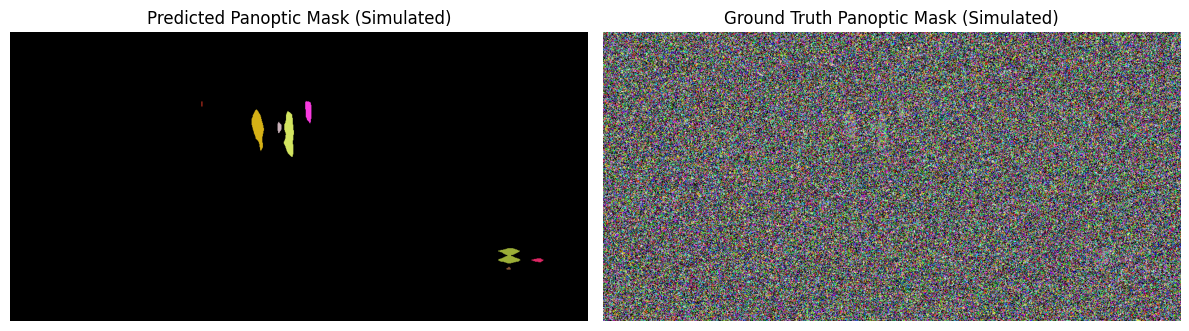

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Function to map panoptic mask to a colorful image
def colorize_panoptic(panoptic_mask):
    unique_ids = np.unique(panoptic_mask)
    color_map = {uid: np.random.rand(3,) for uid in unique_ids if uid != 0}
    color_mask = np.zeros((*panoptic_mask.shape, 3), dtype=np.float32)
    for uid in unique_ids:
        if uid == 0:
            continue  # background stays black
        color_mask[panoptic_mask == uid] = color_map[uid]
    return color_mask

# Create color masks
pred_vis = colorize_panoptic(panoptic_pred)
gt_vis = colorize_panoptic(panoptic_gt)

# Plot side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(pred_vis)
plt.title("Predicted Panoptic Mask (Simulated)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gt_vis)
plt.title("Ground Truth Panoptic Mask (Simulated)")
plt.axis('off')

plt.tight_layout()
plt.show()
